$$
\newcommand{P}[1]{\mathrm{P}\left( #1 \right)}
\newcommand{Pc}[2]{\mathrm{P}\left( #1 \mid #2 \right)}
\newcommand{Ec}[2]{\mathrm{E}\left( #1 \mid #2 \right)}
\newcommand{In}[2]{ #1 \perp\!\!\!\perp #2}
\newcommand{Cin}[3]{ #1 \perp\!\!\!\perp #2 \, | \, #3}
\newcommand{do}[1]{\mathrm{do}\left( #1 \right)}
\newcommand{\ci}{\perp\!\!\!\perp}
$$

# More on Counterfactual Models: Modeling Aproaches

Day 3 Module 3

## Matching Based Methods

We have seen in our smoking study example the usefulness of regression based method in estimating the causal effect ATE. 

In this case the method has done well in identifying the correct ATE - which is good, but the data generating process was specifically designed to meet the assumption on the model form. We have already seen a case where the regression based method failed. In fact, this happens fairly common.

In [1]:
from __future__ import division
from sklearn.preprocessing import PolynomialFeatures
from causalinference import CausalModel

import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

Let us look at the following example, where we have nonlinear relationship:

Now for subject $i$ ($i=1,\cdots,1000$), we generate 

* the confounder $X_i \sim N(0,1)$;
* binary treatment indicator $A$ from $\text{logit}[\Pc{A_i=1}{X_i}]= 0.5 + 0.6X_i$;
* the (true) counterfactuals: 
    - <font color='blue'>$Y^0_i = 2X_i^2 + \epsilon_i$</font>
    - <font color='blue'>$Y^1_i = 3 - 2I(X_i<1) + 2X_i^2 + \epsilon_i$</font>
    - where $\epsilon_i \sim N(0,0.3^2)$
* the observed outcome $Y_i = Y^1_i \times A_i + Y^0_i \times (1 - A_i)$

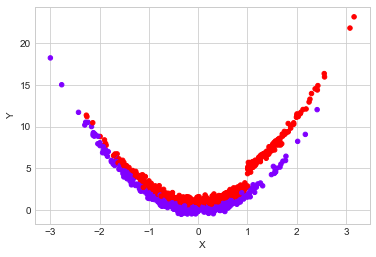

In [2]:
"""
Data Example 2
  
"""
n_samples = 1000
X = np.random.normal(size=n_samples)
p_a = np.exp(0.5 + 0.6*X)/(1 + np.exp(0.5 + 0.6*X))
A = np.random.binomial(n=1, p=p_a, size=n_samples)
eY = 0.3 * np.random.normal(size=n_samples)
Y0 = 2 * X * X + eY
Y1 = np.where(X < 1, Y0+1, Y0+3)
Y = np.where(A == 0, Y0, Y1)
data_example2 = pd.DataFrame({"X":X, "A":A, "Y":Y, "Y0":Y0, "Y1":Y1})
data_example2.plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False)

In [3]:
ctrl_grp = data_example2[data_example2.A == 0]
trt_grp = data_example2[data_example2.A == 1]
alpha = trt_grp.Y.mean() - ctrl_grp.Y.mean()
alpha_err = 1.96 * np.sqrt(
        trt_grp.Y.var() / trt_grp.shape[0] + 
        ctrl_grp.Y.var() / ctrl_grp.shape[0])
print("Estimated Association: {:.3f}".format(alpha), "({:.3f})".format(alpha_err))


theta = data_example2.Y1.mean() - data_example2.Y0.mean()
print("Simulated ATE: {:.3f}".format(theta))
theta1 = ctrl_grp.Y1.mean() - ctrl_grp.Y0.mean()
print("Simulated ATC: {:.3f}".format(theta1))
theta2 = trt_grp.Y1.mean() - trt_grp.Y0.mean()
print("Simulated ATT: {:.3f}".format(theta2))

Estimated Association: 1.188 (0.367)
Simulated ATE: 1.318
Simulated ATC: 1.145
Simulated ATT: 1.420


In [4]:
cm = CausalModel(
    Y=data_example2.Y.values, 
    D=data_example2.A.values, 
    X=data_example2.X.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.311      0.199      6.585      0.000      0.921      1.701
           ATC      0.243      0.210      1.156      0.248     -0.169      0.654
           ATT      1.944      0.227      8.546      0.000      1.498      2.390



## Matching Based Method

Usually this can be overcome by using more powerful estimators . A simple, non-parametric approach, is the technique of [matching](https://en.wikipedia.org/wiki/Matching_%28statistics%29). The idea is to find for each sample which received the treatment, a similar samples which did not receive the treatment, and to directly compare these values. Exactly what you mean by "similar" will depend on your specific usecase.

In our simple example, this means we use a matched observed outcome to imput a missing counterfactual:

| index $i$ | $X_i$ | $A_i$ | $Y_i$ | $Y_i^0$ (matching) | $Y_i^1$ (matching) |
| --- | --- | --- | --- | --- | --- | 
| 1 | 0 | 0 | 4 | <font color='red'>$Y_1$</font> | <font color='green'>$Y_4$</font> |
| 2 | 0 | 0 | 3 | <font color='red'>$Y_2$</font> | <font color='green'>$Y_4$</font> |
| 3 | 0 | 0 | 5 | <font color='red'>$Y_3$</font> | <font color='green'>$Y_4$</font> |
| 4 | 0 | 1 | 8 | <font color='green'>$Y_1$</font> | <font color='red'>$Y_4$</font> |
| 5 | 1 | 0 | 2 | <font color='red'>$Y_5$</font> | <font color='green'>$Y_7$</font> |
| 6 | 1 | 0 | 4 | <font color='red'>$Y_6$</font> | <font color='green'>$Y_7$</font> |
| 7 | 1 | 1 | 8 | <font color='green'>$Y_5$</font> | <font color='red'>$Y_7$</font> |
| 8 | 1 | 1 | 6 | <font color='green'>$Y_5$</font> | <font color='red'>$Y_8$</font> |

For the smoking example, the package `causalinference` implements matching by selecting for each unit, with replacement, the most similar unit from the other treatment group and using the difference between these two units to calculate the ATE. By default, the choice of match is chosen to be the nearest neighbour in covariate space $X$, with the distances weighted by inverse variance of each dimension.

There are options to change the number of units compared and the weighting of each dimension in the match. For more details, see the [documentation](http://laurence-wong.com/software/matching).

We can compute the matching estimate with the following code

In [5]:
cm = CausalModel(
    Y=data_example2.Y.values, 
    D=data_example2.A.values, 
    X=data_example2.X.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.322      0.075     17.572      0.000      1.174      1.469
           ATC      1.085      0.095     11.367      0.000      0.898      1.272
           ATT      1.462      0.082     17.864      0.000      1.302      1.623



The confidence intervals around our estimate now contain the true ATE.

The OLS estimator fails to capture the true effect, while the matching based estimator yields the correct estimation.

# Propensity Score

For dichotomous treatments, we denote the 'true' propensity score as
$e_i=e(\boldsymbol{X}_i)=\Pc{A_i=1}{X_{1i}},X_{2i},\cdots,X_{pi}$.

The propensity score has two fundamental properties in causal inference:
* **Balancing property**: Treatment assignment is conditionally independent of the covariates given the propensity score. 
    - $A_i\ci \boldsymbol{X}_i | e(\boldsymbol{X}_i)$ (sufficient dimension reduction)
* **Unconfoundedness**: Under conditional exchangeability, the counterfactual outcomes are conditionally independent given the propensity score: 
    - $Y_i^a\ci A_i | e(\boldsymbol{X}_i)$ for $a=0,1$

### Balancing Scores
In fact, propensity score is a special case of a more generally defined score function -- Balancing Score

Any function $b(\boldsymbol{X})$ of $\boldsymbol{X}$ satisfies $A \ci \boldsymbol{X}\,|\,b(\boldsymbol{X})$ is called a balancing score. 

**Theorem**:  A function $b(\boldsymbol{X})$ is a balancing score if and only if $b(\boldsymbol{X})$ is “finer” than $e(\boldsymbol{X})$ in the sense that $e(\boldsymbol{X})=f(b(\boldsymbol{X}))$ for some function $f$. 

## Inverse Propensity Score Weighting (Inverse Probability Weighting, IPW)

Remember that the problem of measuring causal inference is that we want to know the quantity $E[Y^{a}]$, but we only have access to samples from $E[Y^{a}|A=a]$.

The density of a potential outcome can be expanded to give

$P(Y^{a}) = P(Y^{a}| A = a)P(A = a)$

This suggests that we can estimate the expectation 

$E[Y^{a}] = E[\frac{Y^{a}}{P(A = a|X)}P(A=a|X)] = E[\frac{Y^{a}}{P(A=a|X)}|A=a, X]$

So if we weight each point by it's inverse propensity, we can recover the potential outcomes. The result is the [inverse propensity score weight estimator](https://en.wikipedia.org/wiki/Inverse_probability_weighting):

$\theta_{ipw} = \frac{1}{N}\left(\sum_{i \in 1} \frac{Y_{i}}{\hat{e}(X_{i})} - \sum_{i \in 0} \frac{Y_{i}}{1 - \hat{e}(X_{i})}\right)$


In our simple example, this means we weight the non-missing counterfactuals to represent the missing counterfactuals:

$\Pc{A_i=1}{X_i=0} = 1/4 \\
 \Pc{A_i=0}{X_i=0} = 3/4 \\
 \Pc{A_i=1}{X_i=1} = 1/2 \\
 \Pc{A_i=0}{X_i=1} = 1/2$, 
 
thus we have

| index $i$ | $X_i$ | $A_i$ | $Y_i$ | $Y_i^0$ (weighting) | $Y_i^1$ (weighting) |
| --- | --- | --- | --- | --- | --- | 
| 1 | 0 | 0 | 4 | <font color='red'>$Y_1$</font>$\times$<font color='green'>$\frac{4}{3}$</font> | |
| 2 | 0 | 0 | 3 | <font color='red'>$Y_2$</font>$\times$<font color='green'>$\frac{4}{3}$</font> | |
| 3 | 0 | 0 | 5 | <font color='red'>$Y_3$</font>$\times$<font color='green'>$\frac{4}{3}$</font> | |
| 4 | 0 | 1 | 8 | | <font color='red'>$Y_4$</font>$\times$<font color='green'>4</font> |
| 5 | 1 | 0 | 2 | <font color='red'>$Y_5$</font>$\times$<font color='green'>2</font> | |
| 6 | 1 | 0 | 4 | <font color='red'>$Y_6$</font>$\times$<font color='green'>2</font> | |
| 7 | 1 | 1 | 8 | | <font color='red'>$Y_7$</font>$\times$<font color='green'>2</font> |
| 8 | 1 | 1 | 6 | | <font color='red'>$Y_8$</font>$\times$<font color='green'>2</font> |


Next, let's see how it does in our data example:

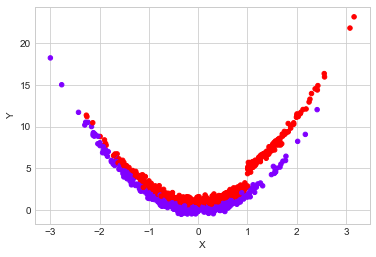

In [6]:
data_example2.plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False);

In [7]:
ctrl_grp = data_example2[data_example2.A == 0]
trt_grp = data_example2[data_example2.A == 1]
alpha = trt_grp.Y.mean() - ctrl_grp.Y.mean()
alpha_err = 1.96 * np.sqrt(
        trt_grp.Y.var() / trt_grp.shape[0] + 
        ctrl_grp.Y.var() / ctrl_grp.shape[0])
print("Estimated Association: {:.3f}".format(alpha), "({:.3f})".format(alpha_err))

theta = data_example2.Y1.mean() - data_example2.Y0.mean()
print("Simulated ATE: {:.3f}".format(theta))

Estimated Association: 1.188 (0.367)
Simulated ATE: 1.318


In practice, we never know $e(X_i)$'s and must use weights based on propensity scores estimated from logistic regression or modeling approaches instead

We can estimate the propensity using the `CausalInference` package's methods `est_propensity_s` or `est_propensity`, which uses logistic regression on the covariate to estimate propensity:

In [8]:
cm.est_propensity_s()
propensity = cm.propensity["fitted"]

data_example2["ipw"] = np.where(
    data_example2.A == 1, 
    1 / propensity,
    1 / (1 - propensity))
data_example2["wY"] = data_example2.Y * data_example2.ipw

psate = data_example2[data_example2.A == 1]["wY"].sum() / data_example2[data_example2.A == 1]["ipw"].sum() - data_example2[data_example2.A == 0]["wY"].sum() / data_example2[data_example2.A == 0]["ipw"].sum()

print("Estimated ATE (by weighting based method): {:.3f}".format(psate))

Estimated ATE (by weighting based method): 1.195


The inverse probability weights we used to estimate ATE is $w_i = \frac{A_i}{e(X_i)} + \frac{1 - A_i}{1 - e(X_i)}$, should we use this to estimate ATT and ATC?

In [9]:
data_example2["cipw"] = np.where(
    data_example2.A == 1, 
    (1 - propensity) / propensity,
    1)
data_example2["cwY"] = data_example2.Y * data_example2.cipw
psatc = data_example2[data_example2.A == 1]["cwY"].sum() / data_example2[data_example2.A == 1]["cipw"].sum() - data_example2[data_example2.A == 0]["cwY"].sum() / data_example2[data_example2.A == 0]["cipw"].sum()
print("Estimated ATC (by weighting based method): {:.3f}".format(psatc))

data_example2["tipw"] = np.where(
    data_example2.A == 1, 
    1,
    propensity / (1 - propensity))
data_example2["twY"] = data_example2.Y * data_example2.tipw
psatt = data_example2[data_example2.A == 1]["twY"].sum() / data_example2[data_example2.A == 1]["tipw"].sum() - data_example2[data_example2.A == 0]["twY"].sum() / data_example2[data_example2.A == 0]["tipw"].sum()
print("Estimated ATT (by weighting based method): {:.3f}".format(psatt))

Estimated ATC (by weighting based method): 0.930
Estimated ATT (by weighting based method): 1.352


This does well in our situation - b is very dependent on how good our estimate of the propensity score is - for the data generator we're using for this examplute the relationship can be described well by plain logistic regression.

$$\def \bX {\textbf {X}}$$
$$\def \balpha {\boldsymbol{\alpha}}$$
$$\def \bbeta {\boldsymbol{\beta}}$$
# Doubly Robust Weighted Estimator

In practice, it might be difficult to know either the true model for outcome, or the true model for the weights, one solutuon is  to combine the inverse propensity score weighting estimators and the linear estimator of effect size together to try and reduce the flaws in either model. 

Such a proposal is called the [doubly robust weighted estimator](https://academic.oup.com/aje/article/173/7/761/103691), or the augmented inverse propensity weighted (AIPW) estimator.

Recall two estimators we have discussed:

* Regression Based Estimator for ATE: 
    - When assumptions are satisfied, we can identify the regression of $Y$ on $A$ and $\boldsymbol{X}$, e.g. for continuous outcome, $E(Y\vert A, \bX)=m(A, \bX; \balpha)=\alpha_0 + \alpha_a A + \bX^T\boldsymbol{\alpha}_X$
    - We can estimate the mean of counterfactual $E(Y^1)$ as ${N}^{-1}\sum_{i=1}^N m(A_i=1, \bX_i; \hat\balpha)$
    - Similarly, we can estimate the mean of counterfactual $E(Y^0)$ as ${N}^{-1}\sum_{i=1}^N m(A_i=0, \bX_i; \hat\balpha)$
    - ATE can then be estimated as the difference between these two quantities
    - It requires that **the outcome model be correctly specified**
    
* Weighting Based Estimator for ATE:
    - When assumptions are satisfied, we can estimate the propensity score from the regression of $A$ on $\bX$, e.g. we postulate a logistic regression model 
    $P(A=1\vert \bX) = e(\bX; \bbeta) = \frac{\exp(\beta_0 + \bX^T\bbeta_1)}{1 + exp(\beta_0 + \bX^T\bbeta_1)}$
    - We can estimate the mean of counterfactual $E(Y^1)$ as $N^{-1}\sum_{i=1}^N (A_iY_i)/{e(\bX_i, \boldsymbol{\hat\beta})}$
    - We can estimate the mean of counterfactual $E(Y^0)$ as $N^{-1}\sum_{i=1}^N (1 - A_i)Y_i/[1 - e(\bX_i, \boldsymbol{\hat\beta})]$
    - ATE can then be estimated as the difference between these two quantities
    - It requires that **the propensity score model be correctly specified**

The Doubly Robust Estimator combines these two proposals, and estimates ATE as 


$\hat\theta_{AIPW} = \hat E(Y^1) - \hat E(Y^0) = N^{-1}\sum_{i=1}^N\left[\frac{A_iY_i}{e(\bX_i, \boldsymbol{\hat\beta})} - \frac{A_i - e(\bX_i, \boldsymbol{\hat\beta})}{e(\bX_i, \boldsymbol{\hat\beta})}m(A_i=1, \bX_i, {\hat\balpha}) \right]
    - N^{-1}\sum_{i=1}^N\left[\frac{(1 - A_i)Y_i}{1 - e(\bX_i, \boldsymbol{\hat\beta})} + \frac{A_i - e(\bX_i, \boldsymbol{\hat\beta})}{1 - e(\bX_i, \boldsymbol{\hat\beta})}m(A_i=0, \bX_i, \hat\balpha) \right]$


Intuitively, if there is big bias in either $m(A_i, \bX_i, \hat\balpha)$ or $e(\bX_i, \boldsymbol{\hat\beta})$, there is an additional term in this new estimator that takes into account the other model. 

It can be shown that if
* The regression model is incorrect but the propensity model is correct
    
    OR
* The propensity model is incorrect but the regression model is correct
    
    then $\hat\theta_{AIPW}$ is a (consistent) estimator for the ATE.

We can apply this estimator in our simulation study:

In [10]:
cm = CausalModel(
    Y=data_example2.Y.values, 
    D=data_example2.A.values, 
    X=data_example2.X.values)

cm.est_propensity_s()
cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.410      0.179      7.864      0.000      1.059      1.762



# Some Practical Issues 

The causal inference tools we discussed so far require the assumptions. Yet, in practice, these assumptions can never be tested. In this section, we will discuss some considerations regarding applying counterfactual modeling approaches in practice.

## About the Positivity Assumption

When there are areas of covariate space which contains only the treated or untreated samples, i.e., there are some subgroup of patients who may hardly be assigned to one treatment arm, then the problem become difficult. We have to extrapolate the effect of the treatment - which will depend heavily on the additional assumptions we imposed on the model structure. 

We may look at the following example:

Now for subject $i$ ($i=1,⋯,1000$), we generate

* the confounder $X_i \sim \text{Uniform}(0,1)$;
* binary treatment indicator $A \sim \text{Bernoulli}(p_{a,i})$, with 

$p_{a,i} = \left\{
\begin{array}{cc}
0 & \text{if }X_i<0.1
\\
X_i & \text{if }0.1\leq X_i \leq 0.9
\\
1 & \text{if }X_i > 0.9
\end{array}
\right.$
* the (true) counterfactuals: 
    - $Y^0_i = -4(X_i - 0.3)\times I(X_i\geq 0.3) + \epsilon_i$
    - $Y^1_i = 1 - 4(X_i - 0.7)\times I(X_i< 0.7) + \epsilon_i$
    - where $\epsilon_i \sim N(0,0.3^2)$
* the observed outcome $Y_i = Y^1_i \times A_i + Y^0_i \times (1 - A_i)$

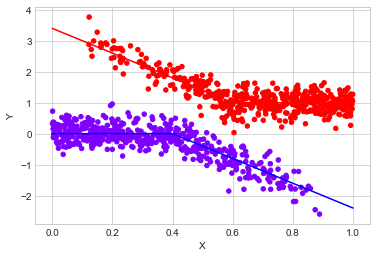

In [11]:
"""
Data Example 3
  
"""
n_samples = 1000
X = np.random.uniform(size=n_samples)
p_a = np.where(X < 0.1, 0, np.where(X > 0.9, 1, X))
A = np.random.binomial(n=1, p=p_a, size=n_samples)
eY = 0.3 * np.random.normal(size=n_samples)
Y0 = np.where(X >= 0.4, -4*(X - 0.4), 0) + eY
Y1 = np.where(X < 0.6,  -4*(X - 0.6), 0) + 1 + eY
Y = np.where(A == 0, Y0, Y1)
data_example3 = pd.DataFrame({"X":X, "A":A, "Y":Y, "Y0":Y0, "Y1":Y1})

data_example3.plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False)
# latent traj
t = np.linspace(0,1,100)
y0 =  np.where(t >= 0.4, -4*(t - 0.4), 0)
y1 =  np.where(t < 0.6,  -4*(t - 0.6), 0) + 1
plt.plot(t, y0, "b")
plt.plot(t, y1, "r")

In [12]:
ctrl_grp = data_example3[data_example3.A == 0]
trt_grp = data_example3[data_example3.A == 1]
alpha = trt_grp.Y.mean() - ctrl_grp.Y.mean()
alpha_err = 1.96 * np.sqrt(
        trt_grp.Y.var() / trt_grp.shape[0] + 
        ctrl_grp.Y.var() / ctrl_grp.shape[0])
print("Estimated Association: {:.3f}".format(alpha), "({:.3f})".format(alpha_err))

theta = data_example3.Y1.mean() - data_example3.Y0.mean()
print("Simulated ATE: {:.3f}".format(theta))

Estimated Association: 1.516 (0.070)
Simulated ATE: 2.432


In [13]:
# OLS estimator
cm = CausalModel(
    Y=data_example3.Y.values, 
    D=data_example3.A.values, 
    X=data_example3.X.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.183      0.037     59.455      0.000      2.111      2.255
           ATC      2.158      0.045     48.236      0.000      2.070      2.245
           ATT      2.208      0.041     53.322      0.000      2.127      2.289



In [14]:
# Matching estimator
cm.est_via_matching()
print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.183      0.037     59.455      0.000      2.111      2.255
           ATC      2.158      0.045     48.236      0.000      2.070      2.245
           ATT      2.208      0.041     53.322      0.000      2.127      2.289

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.502      0.118     21.150      0.000      2.270      2.734
           ATC      2.418      0.183     13.221      0.000      2.059      2.776
           ATT      2.585      0.138     18.667      0.000      2.313      2.856



### Trimming

A simple solution is to only make predictions for the counterfactual in regions where there is a good overlap, or "trim" points where there is not good overlap. For high dimensional data "good overlap" can be difficult to define - using just the propensity score to define overlap is one way to solve this. 

`CausalInference` offers a method to trim the data based on the propensity score

In [19]:
# trimming
cm2 = CausalModel(
    Y=data_example3.Y.values, 
    D=data_example3.A.values, 
    X=data_example3.X.values)

cm2.est_propensity_s()
cm2.trim_s()
cm2.est_via_matching()

print(cm2.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.346      0.062     37.814      0.000      2.224      2.468
           ATC      2.311      0.078     29.460      0.000      2.158      2.465
           ATT      2.379      0.074     32.121      0.000      2.234      2.524



We can look at what is going on here

Simulated ATE: 2.252


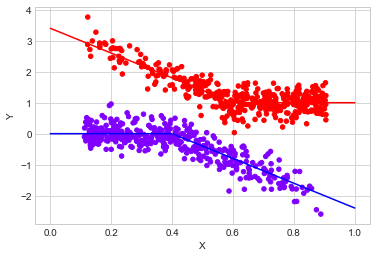

In [20]:
# mask out the trimmed portion
propensity = cm2.propensity["fitted"]
cutoff = cm2.cutoff
mask = (propensity > cutoff) &  (propensity < 1 - cutoff)

# plot the data
data_example3[mask].plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False)

# latent traj
t = np.linspace(0,1,100)
y0 =  np.where(t >= 0.4, -4*(t - 0.4), 0)
y1 =  np.where(t < 0.6,  -4*(t - 0.6), 0) + 1
plt.plot(t, y0, "b")
plt.plot(t, y1, "r")

Basically, what it does is to focus on some subgroup of patients, where the overlapping (between the two treatmeant groups) is better. For the samples left out, we cannot make any causal conclusion due to the violation of the positivity assumption.

### Stratification

Another propensity score based method is stratification (or blocking). It consist of grouping the data points into strata with similar propensity (very similar idea as matching)

We can use the `stratify` (need to provide boundaries) or `stratify_s` (automatically choose the boundaries) methods to determine the strata, and then use `est_via_blocking` method to combine the estimates of different strata to estimate ATE for the entire population:

In [21]:
cm = CausalModel(
    Y=data_example3.Y.values, 
    D=data_example3.A.values, 
    X=data_example3.X.values)

cm.est_propensity_s()
cm.stratify_s()
cm.est_via_blocking()
print(cm.estimates)


Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.477      0.037     66.684      0.000      2.404      2.550
           ATC      2.404      0.064     37.804      0.000      2.280      2.529
           ATT      2.549      0.027     94.766      0.000      2.496      2.601



You can look at the strata

In [22]:
print(cm.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.044     0.093       122         4     0.066     0.090     2.940
         2     0.094     0.176       101        24     0.129     0.138     2.621
         3     0.177     0.342        92        33     0.256     0.268     2.088
         4     0.342     0.511        70        55     0.424     0.435     1.814
         5     0.514     0.821        89       161     0.671     0.685     1.999
         6     0.821     0.864        14        49     0.840     0.847     2.633
         7     0.865     0.900         6        56     0.880     0.883     2.744
         8     0.900     0.951         2       122     0.905     0.930     3.499



Stratify the data into groups by propensity score is useful when we don't have any prior knowledge of what constitutes "similar" units. However if you have prior knowledge the different groups of your samples are likely to be affected by the intervention in similar ways, it is recommended to work on these predefined subgroups and then calculate the overall ATE if needed.